In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import tifffile as tf
import numpy as np
import os
from netCDF4 import Dataset
import rasterio

import matplotlib.patches as mpatches
#import cartopy.crs as ccrs
#import descartes # required to plot polygons
#import cartopy.io.img_tiles as cimgt
from matplotlib.colors import ListedColormap, BoundaryNorm

In [3]:
# User defined settings for pathogen and scenario selection

pathogen = 'E.coli' # select the pathogen for the simulation. Option at the moment is only 'E.coli'
source = 'Sewer_and_pluvial' #select the source of the pathogen. At the moment only 'Sewer_and_pluvial'
conc = 'max' #select the concentration of the pathogen: options are 'min' and 'max'
doseresp = 'poisson' #select the dose response curve of the pathogen for infection calculation. Either 'beta poisson' (keyword: 'poisson') or exponantial ('exp', not yet included)

#form values for poisson distribution
N50 = 896 #constant for the beta poisson infection risk calculation
NoE  = 4  #number of events per year 
alpha = 0.145 #form value for poisson distribution

In [4]:
"""
This part was used to have a small image, than was easy to check. 

with rasterio.open('pop_dens.tif') as src:
    window= rasterio.windows.Window(400, 525, 150, 150)
    subset = src.read(window=window)
    transform = src.window_transform(window)
    meta = src.meta.copy()
    meta.update({
        'height': window.height,
        'width': window.width,
        'transform': transform
    })

 
# Write the subset to a new file   
with rasterio.open('pop_dens_zoom.tif', 'w', **meta) as dst:
    dst.write(subset)

"""

"\nThis part was used to have a small image, than was easy to check. \n\nwith rasterio.open('pop_dens.tif') as src:\n    window= rasterio.windows.Window(400, 525, 150, 150)\n    subset = src.read(window=window)\n    transform = src.window_transform(window)\n    meta = src.meta.copy()\n    meta.update({\n        'height': window.height,\n        'width': window.width,\n        'transform': transform\n    })\n\n \n# Write the subset to a new file   \nwith rasterio.open('pop_dens_zoom.tif', 'w', **meta) as dst:\n    dst.write(subset)\n\n"

### read in maps & plot them

For now, we just read in one time step, exported as tiff file from the sfincs output. What we would like is that we can connect to sfincs (1) and d-hydro (2) output, and at first select 1 timestep to develop the model further, and later on to use the whole model output of sfincs and d-hydro to have floodings statistics per grid cell over a or multiple years to calculate year-round infection risks. 

In [5]:
flooded = tf.imread('../examples/Data bronnen/flooded_zoom.tif')
flooded[flooded < -3.402822e+38] = np.nan

print(np.nanmin(flooded))
print(np.nanmax(flooded))

-10.4919195
11.578357


C:\Users\weeber\AppData\Local\Temp\ipykernel_24120\4175759298.py:8: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(mappable)


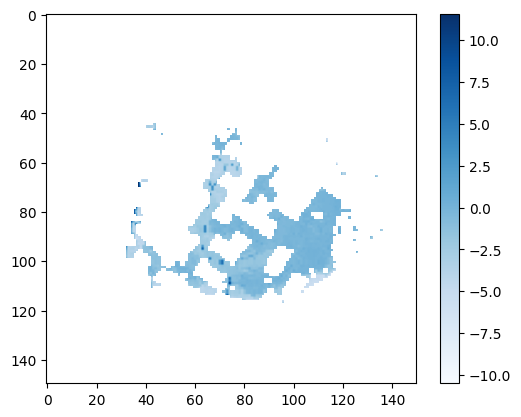

In [6]:
cmap = mpl.colormaps['Blues']
norm = plt.Normalize(vmin=np.nanmin(flooded), vmax=np.nanmax(flooded))
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)

fig, ax = plt.subplots()

im = ax.imshow(flooded, cmap=cmap)
cbar = fig.colorbar(mappable)

plt.show()

In [7]:
"""
This part was used to see whether - or + values were represensting the flooding water depth. Can eventually be deleted.

hist, bins = np.histogram(flooded, bins=10, range=(np.nanmin(flooded), np.nanmax(flooded)))

# Plot the histogram
plt.hist(flooded, bins=20, range=(np.nanmin(flooded),np.nanmax(flooded)))
plt.title("Histogram of flooding classes")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()
"""

'\nThis part was used to see whether - or + values were represensting the flooding water depth. Can eventually be deleted.\n\nhist, bins = np.histogram(flooded, bins=10, range=(np.nanmin(flooded), np.nanmax(flooded)))\n\n# Plot the histogram\nplt.hist(flooded, bins=20, range=(np.nanmin(flooded),np.nanmax(flooded)))\nplt.title("Histogram of flooding classes")\nplt.xlabel("Value")\nplt.ylabel("Frequency")\nplt.show()\n'

In [8]:
popdens = tf.imread('../examples/Data bronnen/pop_dens_zoom.tif')
popdens[popdens < -3.402822e+38] = np.nan

print(np.nanmax(popdens))
print(np.nanmin(popdens))

141.86479
4.25104


C:\Users\weeber\AppData\Local\Temp\ipykernel_24120\661310937.py:9: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(mappable)


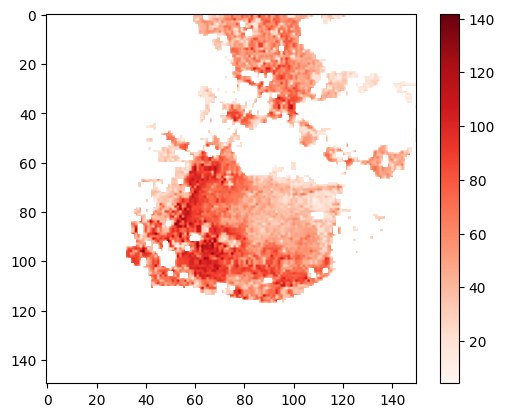

In [9]:
#plot population density map
cmap = mpl.colormaps['Reds']
norm = plt.Normalize(vmin=np.nanmin(popdens), vmax=np.nanmax(popdens))
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)

fig, ax = plt.subplots()

im = ax.imshow(popdens, cmap=cmap)
cbar = fig.colorbar(mappable)

plt.show()

### Visualize & calculate affected population
In the part below, some overlays are made to link flooding to population density to get info how many people are affected by the flood & how they are affected. The latter has been expressed by linking water depth to 'behavior' like wading and swimming.

In [10]:
overl_flarea = np.where(flooded >= np.nanmin(flooded),popdens,np.nan)
overl_dryarea = np.where(np.isnan(flooded),popdens,np.nan)

C:\Users\weeber\AppData\Local\Temp\ipykernel_24120\3481121497.py:8: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(mappable)


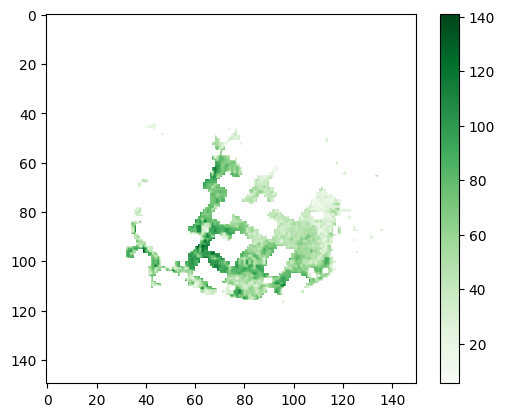

C:\Users\weeber\AppData\Local\Temp\ipykernel_24120\3481121497.py:19: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(mappable)


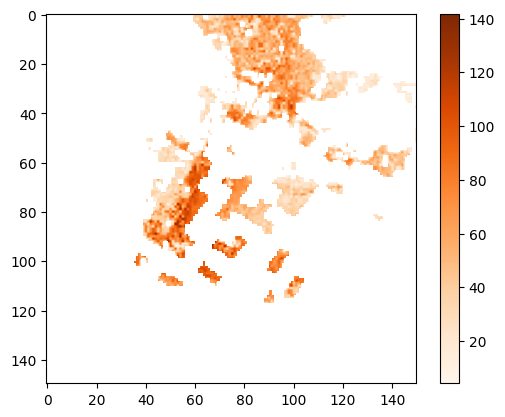

In [11]:
cmap = mpl.colormaps['Greens']
norm = plt.Normalize(vmin=np.nanmin(overl_flarea), vmax=np.nanmax(overl_flarea))
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)

fig, ax = plt.subplots()

im = ax.imshow(overl_flarea, cmap=cmap)
cbar = fig.colorbar(mappable)

plt.show()

cmap = mpl.colormaps['Oranges']
norm = plt.Normalize(vmin=np.nanmin(overl_dryarea), vmax=np.nanmax(overl_dryarea))
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)

fig, ax = plt.subplots()

im = ax.imshow(overl_dryarea, cmap=cmap)
cbar = fig.colorbar(mappable)

plt.show()

In [12]:
print('total inhabitants in total area:', round(np.nansum(popdens),0))
print('total inhabitants in flooded area:', round(np.nansum(overl_flarea),0), '(', round((np.nansum(overl_flarea)/np.nansum(popdens))*100,0),'%)')
print('total inhabitants in dry area:', round(np.nansum(overl_dryarea),0), '(', round((np.nansum(overl_dryarea)/np.nansum(popdens))*100,0),'%)')

total inhabitants in total area: 347166.0
total inhabitants in flooded area: 137904.0 ( 40.0 %)
total inhabitants in dry area: 209261.0 ( 60.0 %)


### Relate pathogen concentration to exposure levels
In this part, four flooding water depths are assumed: 0-0.10 (value 1), 0.1-0.5 (value 2),0.5-1.5 (value 3)and >1.5 (value 4). It is assumed that value 1 has no additional expore to not flooded, value 2 relates to wading of both children and adults, value 3 to swimming of children and wading by adults and value 4 both children and adults swim 


In [13]:
wclass = flooded.copy()
wclass[wclass>0]=np.nan
wclass[np.logical_and(wclass<0,wclass>=-0.1)]= 1
wclass[np.logical_and(wclass<-0.1,wclass>=-0.5)]=2
wclass[np.logical_and(wclass<-0.5,wclass>=-1.5)]=3
wclass[wclass<-1.5]= 4


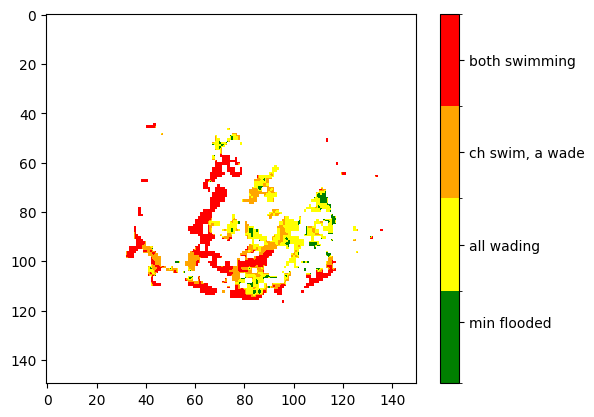

In [14]:
cmap = ListedColormap(['green', 'yellow', 'orange', 'red'])
bounds = [0, 1.5, 2.5, 3.5, 4.5]
norm = BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots()

im = ax.imshow(wclass, cmap=cmap, norm=norm)
cbar = fig.colorbar(im, ticks=[1,2, 3,4], boundaries=bounds)
cbar.ax.set_yticklabels(['min flooded', 'all wading', 'ch swim, a wade', 'both swimming'])
plt.show()

In [15]:
np.nansum(wclass[wclass==1])

194.0

In [16]:
# make distinction between adults&children
# together with population data you know how many in each class, which can be highlighted in maps
print('total inhabitants in minimum flooded area:', round(np.nansum(wclass[wclass==1]),0),'(',round((np.nansum(wclass[wclass==1])/np.nansum(wclass))*100,0),'%)')
print('total inhabitants in area where everyone is wading:', round(np.nansum(wclass[wclass==2]),0),'(',round((np.nansum(wclass[wclass==2])/np.nansum(wclass))*100,0),'%)')
print('total inhabitants in area where children swim and adults wade:', round(np.nansum(wclass[wclass==3]),0),'(',round((np.nansum(wclass[wclass==3])/np.nansum(wclass))*100,0),'%)')
print('total inhabitants in area where everyone is swimming:', round(np.nansum(wclass[wclass==4]),0),'(',round((np.nansum(wclass[wclass==4])/np.nansum(wclass))*100,0),'%)')

# exposure data should be read in from text file
# read in dose response relations (via text file - link to different modules)

total inhabitants in minimum flooded area: 194.0 ( 3.0 %)
total inhabitants in area where everyone is wading: 1416.0 ( 21.0 %)
total inhabitants in area where children swim and adults wade: 1494.0 ( 22.0 %)
total inhabitants in area where everyone is swimming: 3648.0 ( 54.0 %)


In [18]:
# read in pathogen concentrations & select concentration
# TODO: for testing purposes a simple text file is used, but ideally, this kind of info should be written/defined within a yml file to set up the model

file = open("../examples/Data bronnen/Scenarios.txt", "r")
for line in file:
    if "E.coli" in line:
        Scenario = line.strip().split(',')
        #print(Scenario)
file.close()

# loops should be incorporated/or working with functions....

if Scenario[0]==pathogen:
    print('Selected pathogen:',Scenario[0])
    if Scenario[1]==source:
        print('used source:',Scenario[1])
        unit = Scenario[4]
        print('used unit:',unit)
        if conc=='min':
            PathConc = Scenario[2]
            print('Using minimum concentration:', PathConc)
        elif conc == 'max':
            PathConc = Scenario[3]
            print('Using maximum concentration:', PathConc)
        else:
            print('No concentration data found for the inserted scenario')

PathConc = float(PathConc.strip().strip("'"))

FileNotFoundError: [Errno 2] No such file or directory: '../examples/Data bronnen/Scenarios.txt'

In [19]:
# read in exposure data & calculation of the dose
# TODO: for testing purposes a simple text file is used, but ideally, this kind of info should be written/defined within a yml file to set up the model
file = open("../examples/Data bronnen/Exposure.txt", "r")
for line in file:
    if "E.coli" in line:
        Exposure = line.strip().split(',')
        print(Exposure)
file.close()

if Scenario[0]==pathogen:
    print('Selected pathogen:',Scenario[0])
    Ad_sp = float(Exposure[1].strip().strip("'"))
    Ad_sw = float(Exposure[2].strip().strip("'"))
    Ch_pl = float(Exposure[3].strip().strip("'"))
    Ch_sw = float(Exposure[4].strip().strip("'"))


dAd_sp = (PathConc/1000)*Ad_sp
dAd_sw = (PathConc/1000)*Ad_sw

dCh_pl = (PathConc/1000)*Ch_pl
dCh_sw = (PathConc/1000)*Ch_sw

print(dAd_sp)
print(dAd_sw)
print(dCh_pl)
print(dCh_sw)

FileNotFoundError: [Errno 2] No such file or directory: '../examples/Data bronnen/Exposure.txt'

In [20]:
# display on map
wclass[wclass==1]=np.nan
dose_ad = wclass.copy()
dose_ad[np.logical_or(dose_ad==2,dose_ad==3)] = dAd_sp
dose_ad[dose_ad==4] = dAd_sw

dose_ch = wclass.copy()
dose_ch[dose_ch==2] = dCh_pl
dose_ch[np.logical_or(dose_ch==3,dose_ch==4)] = dCh_sw



NameError: name 'dAd_sp' is not defined

C:\Users\harezlak\AppData\Local\Temp\ipykernel_5560\1365893742.py:8: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(mappable)


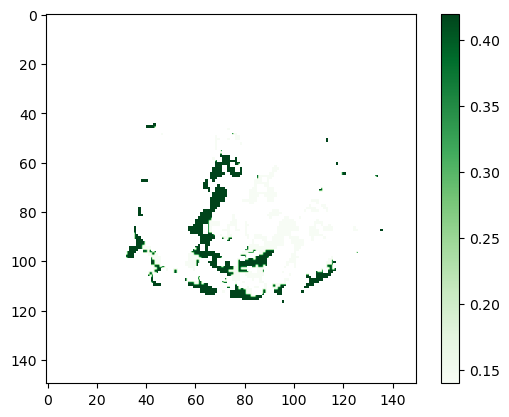

C:\Users\harezlak\AppData\Local\Temp\ipykernel_5560\1365893742.py:19: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(mappable)


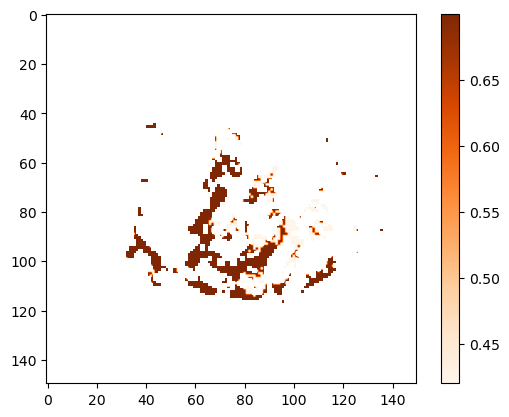

In [99]:
cmap = mpl.colormaps['Greens']
norm = plt.Normalize(vmin=np.nanmin(dose_ad), vmax=np.nanmax(dose_ad))
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)

fig, ax = plt.subplots()

im = ax.imshow(dose_ad, cmap=cmap)
cbar = fig.colorbar(mappable)

plt.show()

cmap = mpl.colormaps['Oranges']
norm = plt.Normalize(vmin=np.nanmin(dose_ch), vmax=np.nanmax(dose_ch))
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)

fig, ax = plt.subplots()

im = ax.imshow(dose_ch, cmap=cmap)
cbar = fig.colorbar(mappable)

plt.show()

In [110]:
# calculate infection risk. Ideally the formula comes from yml (perhaps) in combi with module that does the actual calculations.)
InfRisk_Ad_sp = 1 - (1+(dAd_sp/N50)*(2**(1/alpha)-1))**-alpha
InfRisk_Ad_sw = 1 - (1+(dAd_sw/N50)*(2**(1/alpha)-1))**-alpha

InfRisk_Ch_pl = 1 - (1+(dCh_pl/N50)*(2**(1/alpha)-1))**-alpha
InfRisk_Ch_sw = 1 - (1+(dCh_sw/N50)*(2**(1/alpha)-1))**-alpha

print(InfRisk_Ad_sp)
print(InfRisk_Ad_sw)
print(InfRisk_Ch_pl)
print(InfRisk_Ch_sw)


0.002648760008314932
0.00778510985757197
0.00778510985757197
0.012719726386281938


In [111]:
# display on map
inf_ad = wclass.copy()
inf_ad[np.logical_or(inf_ad==2,inf_ad==3)] = InfRisk_Ad_sp
inf_ad[inf_ad==4] = InfRisk_Ad_sw

inf_ch = wclass.copy()
inf_ch[inf_ch==2] =InfRisk_Ch_pl
inf_ch[np.logical_or(inf_ch==3,inf_ch==4)] = InfRisk_Ch_sw

C:\Users\harezlak\AppData\Local\Temp\ipykernel_5560\1767858925.py:8: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(mappable)


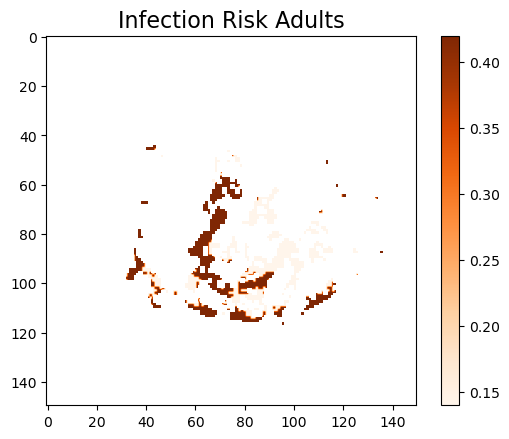

C:\Users\harezlak\AppData\Local\Temp\ipykernel_5560\1767858925.py:19: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(mappable)


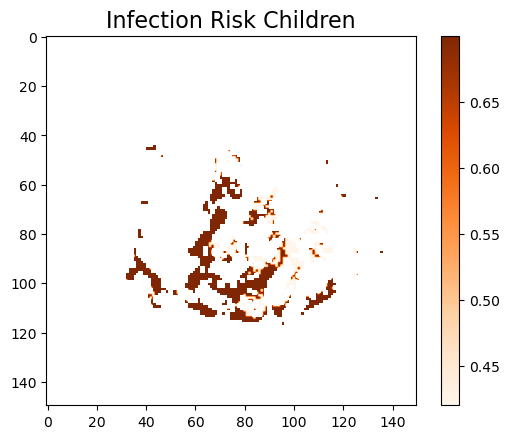

In [118]:
cmap = mpl.colormaps['Oranges']
norm = plt.Normalize(vmin=np.nanmin(dose_ad), vmax=np.nanmax(dose_ad))
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)

fig, ax = plt.subplots()
plt.title('Infection Risk Adults', fontsize=16, color='black')
im = ax.imshow(dose_ad, cmap=cmap)
cbar = fig.colorbar(mappable)

plt.show()

cmap = mpl.colormaps['Oranges']
norm = plt.Normalize(vmin=np.nanmin(dose_ch), vmax=np.nanmax(dose_ch))
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)

fig, ax = plt.subplots()
plt.title('Infection Risk Children', fontsize=16, color='black')
im = ax.imshow(dose_ch, cmap=cmap)
cbar = fig.colorbar(mappable)

plt.show()


### further developments
- Couple to age density map, to distinguish between children and adults.
- Couple to GDP or something to locate slums etc to specify exposure routes further
- Couple to EM/delwaq for spatially varying pathogen concentrations.